In [1]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [2]:
pf = Profiler(workers=2, tol=1e-6, eps=0.05, embedtxt=True)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [3]:
pf.session.load_data(name='hospital', src=FILE, fpath='data/hospital.csv', check_param=True, na_values='empty')

INFO:profiler.utility:[0.006932973861694336] Load Data start

INFO:profiler.data.dataset:parameters used for data loading:
 {'na_values': 'empty', 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.data.dataset:inferred types of attributes: {
    "ProviderNumber": "text",
    "HospitalName": "text",
    "Address1": "text",
    "City": "text",
    "State": "categorical",
    "ZipCode": "text",
    "CountyName": "text",
    "PhoneNumber": "text",
    "HospitalType": "text",
    "HospitalOwner": "text",
    "EmergencyService": "categorical",
    "Condition": "text",
    "MeasureCode": "text",
    "MeasureName": "text",
    "Score": "text",
    "Sample": "text",
    "Stateavg": "text"
}
INFO:profiler.data.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.data.dataset:inferred operators of attributes: {'ProviderNumber': ['equal'], 'HospitalName': ['equal'], 'Address

### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [4]:
pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
                            [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
                            [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

INFO:profiler.data.dataset:updated types of ProviderNumber to 'categorical'
INFO:profiler.data.dataset:updated operators of ProviderNumber to ['equal']
INFO:profiler.data.dataset:updated types of ZipCode to 'numeric'
INFO:profiler.data.dataset:updated operators of ZipCode to ['equal']
INFO:profiler.data.dataset:updated types of PhoneNumber to 'categorical'
INFO:profiler.data.dataset:updated operators of PhoneNumber to ['equal']
INFO:profiler.data.dataset:updated types of State to 'text'
INFO:profiler.data.dataset:updated operators of State to ['equal']
INFO:profiler.data.dataset:updated types of EmergencyService to 'text'
INFO:profiler.data.dataset:updated operators of EmergencyService to ['equal']
INFO:profiler.data.dataset:updated types of Score to 'numeric'
INFO:profiler.data.dataset:updated operators of Score to ['equal']
INFO:profiler.data.dataset:updated types of Sample to 'numeric'
INFO:profiler.data.dataset:updated operators of Sample to ['equal']
INFO:profiler.data.dataset:upd

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [5]:
pf.session.load_embedding(save=True, path='data/hospital/', load=True)

INFO:profiler.utility:[0.10750699043273926] Load Embedding start

INFO:profiler.utility:[0.15359115600585938] Load Embedding execution time: 0.04608416557312012



In [6]:
# load clean data

In [7]:
pf2 = Profiler(workers=2, tol=1e-6, eps=0.05, embedtxt=True)
pf2.session.load_data(name='hospital', src=FILE, fpath='data/hospital_clean_unflatten.csv', check_param=True, na_values='empty')
pf2.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
                            [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
                            [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

INFO:profiler.utility:[4.887580871582031e-05] Load Data start

INFO:profiler.data.dataset:parameters used for data loading:
 {'na_values': 'empty', 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.data.dataset:inferred types of attributes: {
    "ProviderNumber": "numeric",
    "HospitalName": "text",
    "Address1": "text",
    "City": "text",
    "State": "categorical",
    "ZipCode": "numeric",
    "CountyName": "text",
    "PhoneNumber": "numeric",
    "HospitalType": "categorical",
    "HospitalOwner": "categorical",
    "EmergencyService": "categorical",
    "Condition": "categorical",
    "MeasureCode": "text",
    "MeasureName": "text",
    "Score": "text",
    "Sample": "text",
    "Stateavg": "text"
}
INFO:profiler.data.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.data.dataset:inferred operators of attributes: {'ProviderNumber': ['equal'], 'Hos

In [8]:
clean = pf2.session.ds.df['HospitalName']
dirty = pf.session.ds.df['HospitalName']
vec = pf.session.embed.models['HospitalName'].vec
vocab = pf.session.embed.models['HospitalName'].vocab

In [9]:
vocab.loc[np.nan] = vocab.shape[0]

In [10]:
import sklearn
# 1. calculate cosine distances with all other values in the domain 
distance = sklearn.metrics.pairwise.cosine_distances(vec)

In [12]:
import pandas as pd
dis_with_same = []
dis_with_other = []
for i, cell in enumerate(vocab.index):
    if not isinstance(cell, np.str):
        continue
    # for each word, find the corresponding correct word in clean data
    clean_cell = clean.loc[dirty.index[dirty==cell][0]]
    # find the index of the words in dirty vocab that equals to this word in groudtruth
    variations = dirty[(clean==clean_cell) & (dirty != cell)]
    variations = np.unique(variations[~pd.isnull(variations)])
    if len(variations) == 0:
        continue
    print("cell: %s"%cell)
    print("\n-- variations -- ")
    print(variations)
    similar_idx = vocab.loc[variations,'index'].values
    same_idx = [vocab.loc[cell, 'index']]
    dis = distance[i, similar_idx]
    dis_with_same.extend(dis)
    print("\n-- similar words but with large distances --")
    for word, dis in zip(vocab.index.values[similar_idx[dis>0.5]], dis[dis>0.5]):
        print("%s (%.4f)"%(word, dis))
    dis_with_other.extend(distance[i, list(set(vocab['index'].values) - set(similar_idx) - set(same_idx))])
    print("\n====")

cell: alaska regional hospital

-- variations -- 
['xlxskx regionxl hospitxl']

-- similar words but with large distances --

====
cell: andalusia regional hospital

-- variations -- 
['andaluxia regional hoxpital' 'andaxusia regionax hospitax']

-- similar words but with large distances --

====
cell: andaluxia regional hoxpital

-- variations -- 
['andalusia regional hospital' 'andaxusia regionax hospitax']

-- similar words but with large distances --

====
cell: andaxusia regionax hospitax

-- variations -- 
['andalusia regional hospital' 'andaluxia regional hoxpital']

-- similar words but with large distances --

====
cell: baptist medical center south

-- variations -- 
['baptist medical cexter south']

-- similar words but with large distances --
baptist medical cexter south (0.5123)

====
cell: baptist medical cexter south

-- variations -- 
['baptist medical center south']

-- similar words but with large distances --
baptist medical center south (0.5123)

====
cell: communit

Text(0, 0.5, 'count')

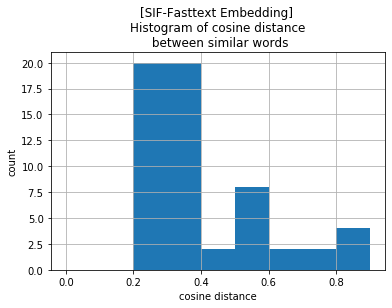

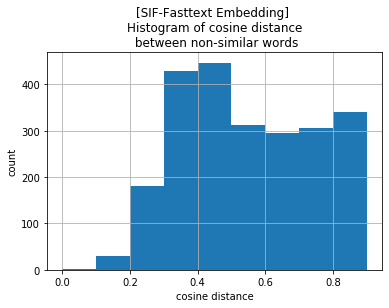

In [14]:
data1 = pd.DataFrame(data=dis_with_same)
ax1 = data1.hist(bins=np.arange(0,1,0.1))[0][0]
ax1.set_title('[SIF-Fasttext Embedding] \nHistogram of cosine distance\n between similar words')
ax1.set_xlabel('cosine distance')
ax1.set_ylabel('count')
data2 = pd.DataFrame(data=dis_with_other)
ax2 = data2.hist(bins=np.arange(0,1,0.1))[0][0]
ax2.set_title('[SIF-Fasttext Embedding] \nHistogram of cosine distance\n between non-similar words')
ax2.set_xlabel('cosine distance')
ax2.set_ylabel('count')